In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [3]:
# 読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 画像データ→行データ
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 分割(訓練データ・評価データ
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# one-hotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_val[:, np.newaxis])

/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove t

In [5]:
X_train.shape

(48000, 784)

In [6]:
# 問題1 全結合層のクラス化

#%%

class FC:
    """全結合層"""
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        """コンストラクタ
        Parameters
        ----------
        n_nodes1 : 前の層のノード数
        n_nodes2 : 当該層のノード数
        initializer : 初期化インスタンス
        optimizer : 勾配更新手法
        """
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        # 初期化インスタンスの関数実行
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        # 最適化インスタンス
        self.optimizer = optimizer
        # 勾配更新の際に使用（AdaGradのみ）
        self.HW = 0
        self.HB = 0
        
    def forward(self, X):
        """順伝播
        Parameters
        ----------
        X : 順伝播されてきた値
        """
        # 逆伝播時に使用
        self.Z = X
        # 順伝播計算部分本体
        self.A = X @ self.W + self.B
        return self.A
    
    def backward(self, dA):
        """逆伝播
        Parameters
        ----------
        dA : 前の層から逆伝播してきた値（活性化関数の逆伝播の値が入ってくる）
        
        Overview
        ----------
        前回のSprint9 ニューラルネットワークでは下記のような逆伝播処理になっていた
            0 ## 2層目
            1 dZ2 = dA3 @ self.W3.T
            2 dA2 = dZ2 * (1 - self.tanh_function(self.A2)**2)
            3 dW2 = self.Z1.T @ dA2
            4 dB2 = np.sum(dA2, axis=0)
            5 ## 1層目
            6 dZ1 = dA2 @ self.W2.T
            7 dA1 = dZ1 * (1 - self.tanh_function(self.A1)**2)
            8 dW1 = X.T @ dA1
            9 dB1 = np.sum(dA1, axis=0)
        勾配の計算
            ここでは、活性化関数の逆伝播は別で実装し、その値をこの関数の引数として受け取っているので、
            この関数の  dA  は、Sprint9の上記の  dA2  に該当する
            よって、上記3,4に該当する処理を書いていけばいい
        逆伝播の値の計算
            活性化関数の逆伝播に渡してやる値、つまりSprint9の上記の  dZ1  に該当する
        重み更新
            勾配dB,dWが計算されているので、このインスタンス自身をoptimizerインスタンスのupdate関数に渡してやる
            optimizerインスタンスのupdate関数の引数は、layerとなっているので、update関数内では、layer.変数名で
            このインスタンスの各種メンバ変数にアクセスできる
        """
        # バイアス項の勾配
        self.dB = np.sum(dA, axis=0)
        # バイアス項以外の勾配
        self.dW = self.Z.T @ dA
        # 逆伝播させる値
        self.dZ = dA @ self.W.T
        # 重み更新
        self = self.optimizer.update(self)
        return self.dZ


In [7]:
# 問題2　初期化方法のクラス化

#%%

class SimpleInitializer:
    """各種重みの初期化"""
    def __init__(self, sigma):
        """コンストラクタ
        Parameters
        ----------
        sigma : 重みの初期化の際のガウス分布の標準偏差
        """
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes1 : 前の層のノード数
        n_nodes2 : 当該層のノード数
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes2 : 当該層のノード数
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [8]:
# 問題3　最適化手法のクラス化

#%%

class SGD:
    """勾配更新手法"""
    def __init__(self, lr):
        """コンストラクタ
        Parameters
        ----------
        lr : 学習率
        """
        self.lr = lr
        
    def update(self, layer):
        """更新
        Parameters
        ----------
        layer : FCクラスのインスタンス
        
        Overview
        ----------
        FCクラス内のbackward関数内で下記の要に実行されている
            0 self.optimizer.update(self)
        引数に「FCクラスのインスタンス自身」が入っていることを考えると
        layer.dW , layer.dB , layer.Z は「FCクラスのインスタンスのメンバ変数」にアクセスしていると考えられる
        """
        layer.W -= self.lr * layer.dW / len(layer.Z)
        layer.B -= self.lr * layer.dB / len(layer.Z)
        return layer

In [9]:
# 問題4　活性化関数のクラス化

#%%

class Sigmoid:
    """シグモイド関数"""
    def forward(self, A):
        """順伝播
        Parameters
        ----------
        A : 順伝播されてきた値
        """
        self.A = A
        Z = 1 / (1 + np.exp(-self.A))
        return Z
    
    def backward(self, dZ):
        """逆伝播
        Parameters
        ----------
        dZ : 逆伝播されてきた値
        """
        dA = dZ * ((1 / (1 + np.exp(-self.A))) - (1 / (1 + np.exp(-self.A)))**2)
        return dA

#%%

class Tanh:
    """tanh関数"""
    def forward(self, A):
        """順伝播
        Parameters
        ----------
        A : 順伝播されてきた値
        """
        self.A = A
        Z = np.tanh(self.A)
        return Z
    
    def backward(self, dZ):
        """逆伝播
        Parameters
        ----------
        dZ : 逆伝播されてきた値
        """
        dA = dZ * (1 - np.tanh(self.A)**2)
        return dA

#%%

class Softmax:
    """Softmax関数"""
    def forward(self, A): 
        """順伝播
        Parameters
        ----------
        A : 順伝播されてきた値
        """
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return Z
        
    def backward(self, Z, y):
        """逆伝播
        Parameters
        ----------
        Z : 出力値
        y : 正解データ
        """
        # 逆伝播の値
        dA = Z - y
        # 損失
        loss = - np.sum(y * np.log(Z)) / len(y)
        return dA, loss


In [15]:
# 問題5　ReLUクラスの作成

#%%

class ReLU:
    """ReLU関数"""
    def forward(self, A):
        """順伝播
        Parameters
        ----------
        A : 順伝播されてきた値
        """
        self.A = A
        Z = np.maximum(0, A)
        return Z
    
    def backward(self, dZ):
        """逆伝播
        Parameters
        ----------
        dZ : 逆伝播されてきた値
        """
        dA = dZ * np.where(self.A > 0, 1, 0)
        return dA


In [17]:
# 問題6　重みの初期値

# 全体の構造としては、`SimpleInitializer`と同じで、W,B関数で、それぞれ初期化された重みを返してやっている

#%%

class XavierInitializer:
    """Xavierの初期化クラス"""
    def __init__(self, sigma):
        """コンストラクタ
        Parameters
        ----------
        sigma : 使用されていない
        
        Overview
        ----------
        なぜ使用されていないのに、引数として受け取っているのか
        
        初期化クラスは、概略すると、下記のように使用されている
        
        呼び出しの大元
            dnn = ScratchDeepNeuralNetrowkClassifier(initializer=SGD or XavierInitializer or HeInitializer) 
            
        定義部分(ScratchDeepNeuralNetrowkClassifier)
            class ScratchDeepNeuralNetrowkClassifier:
                def __init__(self,xxx,xxx,xxx,initializer):
                    .....
                    self.initializer = initializer
                    .....
                def fit(self,xxx,xxx,xxx):
                    self.initializer(self.sigma)
        
        つまり、
        「呼び出しの大元」で、どの初期化クラスが渡されるかわからないので、
        初期化クラスによっては、sigmaが必要なものと、別途計算が必要なものがあるので、
        同じ呼び出し方をしてやるために、この初期かクラスのコンストラクタでも引数として、sigmaを受け取っている
        
        同じ呼び出し方をしてやらないのであれば、上記fitは、下記のような書き方でも可能
            if initializerのクラス名 == "SGD":
                self.initializer(self.sigma)
            else initializerのクラス名 != "SGD":
                self.initializer()
        """
        _ = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes1 : 前の層のノード数
        n_nodes2 : 当該層のノード数
        """
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
        
    def B(self, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes2 : 当該層のノード数
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

#%%

class HeInitializer:
    """Heの初期化クラス"""
    def __init__(self, sigma):
        _ = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes1 : 前の層のノード数
        n_nodes2 : 当該層のノード数
        """
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """コンストラクタ
        Parameters
        ----------
        n_nodes2 : 当該層のノード数
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [18]:
# 問題7　最適化手法

#%%

class AdaGrad:
    """最適化手法（AdaGrad）"""
    def __init__(self, lr):
        """コンストラクタ
        Parameters
        ----------
        lr : 学習率
        """
        self.lr = lr 
    
    def update(self, layer):
        """コンストラクタ
        Parameters
        ----------
        layer : layerインスタンス
        """
        layer.HW += layer.dW * layer.dW
        layer.HB += layer.dB * layer.dB
        delta = 1e-7 # 0割エラー防止のため
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.HW) + delta) / len(layer.Z)
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.HB) + delta) / len(layer.Z)
        return layer


In [19]:
# 問題8　クラスの完成

#%%

class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        """通常のコンストラクタと同様の働き
        Parameters
        ----------
        X : 説明変数（画像の1次元データ）
        y : 目的変数（ラベル）
        batch_size : 必要なミニバッチのデータ数
        seed : ランダムシード固定
        """
        # ランダムシードの固定（学習ごとに同じ生成順）
        np.random.seed(seed)
        # バッチ数のメンバ変数
        self.batch_size = batch_size
        # データ全体の長さ分のインデックスをランダムに並べ替え
        # np.random.permutation:配列をランダムに並べ替え
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        # 並べ替えたインデックスと同じ順番で説明変数と目的変数を並べ替え
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        # データ数をバッチ数で割って、何回呼び出せば、全データを学習したことになるかの判定
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop
    
    def __iter__(self):
        # 何回目の呼び出しか
        self._counter = 0
        return self

    def __next__(self):
        # 全データを学習すればストップ
        if self._counter >= self._stop:
            raise StopIteration()
        # 並び変えた_X,_yの何番目のインデックスを採用するか
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        # returnする前にカウンタに+1しておく
        self._counter += 1
        # 説明変数と目的変数を返す
        return self._X[p0:p1], self._y[p0:p1]

#%%

class ScratchDeepNeuralNetrowkClassifier():

    def __init__(self,batch_size=20,n_features=784,n_nodes1 =400,n_nodes2 = 200,n_output =10,lr =0.005,epoch=10,sigma=0.02,optimizer=SGD, initializer=HeInitializer,activater=ReLU,output_activater=Softmax,verbose=True):
        """コンストラクタ
        Parameters
        ----------
        batch_size : バッチサイズ（default:20)
        n_features : 説明変数の数（default:784)
        n_nodes1 : 前の層のノード数（default:400)
        n_nodes2 : 当該層のノード数（default:200)
        n_output : 出力層のノード数（default:10)
        sigma : 初期化時のパラメータ（default:0.02)
        lr : 学習率（default:0.005)
        verbose : 計算過程の出力（default:True)
        epoch : 学習回数（default:10)
        optimizer : 最適化手法（default:SGD)
        initializer : 初期化方法（default:HeInitializer）
        activater : 活性化関数（default:ReLU）
        """
        self.batch_size = batch_size
        self.n_features = n_features 
        self.n_nodes1 = n_nodes1  
        self.n_nodes2 = n_nodes2 
        self.n_output = n_output
        self.lr = lr
        self.epoch = epoch
        self.optimizer = optimizer 
        self.sigma = sigma
        self.initializer = initializer 
        self.activater = activater
        self.output_activater = output_activater 
        self.verbose = verbose
    
    def fit(self, X, y, X_val=None, y_val=None):
        """学習
        Parameters
        ----------
        X : 訓練データの説明変数
        y : 訓練データの目的変数
        X_val : 評価データの説明変数
        y_val : 評価データの目的変数
        """
        # lossの記録用配列
        self.loss_train = [] 
        self.loss_val = [] 
        # 最適化手法の初期化
        optimizer = self.optimizer(self.lr)
        # 各層の初期化
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), optimizer)
        self.activation1 = self.activater()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), optimizer)
        self.activation2 = self.activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation3 = self.output_activater()
        
        # 学習回数分ループ
        for i in range(self.epoch):
            # ミニバッチイテレータ生成
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            # ミニバッチイテレータループ
            for mini_X, mini_y in get_mini_batch:
                ## 順伝播
                # 1層目
                A1 = self.FC1.forward(mini_X)
                Z1 = self.activation1.forward(A1)
                # 2層目
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                # 3層目
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                ## 逆伝播
                dA3, loss = self.activation3.backward(Z3, mini_y)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) 
                
            # 過程出力
            if self.verbose:
                ## 順伝播
                # 1層目
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                # 2層目
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                # 3層目
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)      
                # 損失計算と記録
                loss = self.activation3.backward(Z3, y)[1]
                self.loss_train.append(loss)
                print('epoch:%d train_loss:%f'%(i,loss))
                # 評価データ見る
                if X_val is not None:
                    ## 順伝播
                    # 1層目
                    A1 = self.FC1.forward(X_val)
                    Z1 = self.activation1.forward(A1)
                    # 2層目
                    A2 = self.FC2.forward(Z1)
                    Z2 = self.activation2.forward(A2)
                    # 3層目
                    A3 = self.FC3.forward(Z2)
                    Z3 = self.activation3.forward(A3)
                    # 損失計算と記録
                    self.loss_val.append(self.activation3.backward(Z3, y_val)[1])
    
    def predict(self, X):
        """予測
        Parameters
        ----------
        X : 入力配列
        """
        ## 順伝播
        # 1層目
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        # 2層目
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        # 3層目
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        # 最も大きいインデックスを採用
        return np.argmax(Z3, axis=1)

/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


epoch:0 train_loss:1.325126
epoch:1 train_loss:0.830070
epoch:2 train_loss:0.621605
epoch:3 train_loss:0.513638
epoch:4 train_loss:0.449630
epoch:5 train_loss:0.405368
epoch:6 train_loss:0.372098
epoch:7 train_loss:0.347720
epoch:8 train_loss:0.325894
epoch:9 train_loss:0.314186
epoch:10 train_loss:0.296136
epoch:11 train_loss:0.281415
epoch:12 train_loss:0.276707
epoch:13 train_loss:0.259010
epoch:14 train_loss:0.253429
epoch:15 train_loss:0.239743
epoch:16 train_loss:0.230993
epoch:17 train_loss:0.224728
epoch:18 train_loss:0.216890
epoch:19 train_loss:0.210665
epoch:20 train_loss:0.205702
epoch:21 train_loss:0.195459
epoch:22 train_loss:0.190220
epoch:23 train_loss:0.184307
epoch:24 train_loss:0.177610
epoch:25 train_loss:0.173838
epoch:26 train_loss:0.169237
epoch:27 train_loss:0.166084
epoch:28 train_loss:0.158714
epoch:29 train_loss:0.157510
epoch:30 train_loss:0.148897
epoch:31 train_loss:0.146653
epoch:32 train_loss:0.140905
epoch:33 train_loss:0.137274
epoch:34 train_loss:0.13

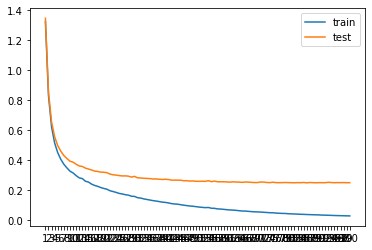

In [20]:
# 問題9　学習と推定

#%%

dnn = ScratchDeepNeuralNetrowkClassifier(epoch=100) 

dnn.fit(X_train[:4000], y_train_one_hot[:4000], X_val[:2000], y_test_one_hot[:2000])

#%%

pred = dnn.predict(X_val)
accuracy_score(y_val, pred)

#%%

plt.plot(list(range(1, dnn.epoch+1)), dnn.loss_train, label='train')
plt.plot(list(range(1, dnn.epoch+1)), dnn.loss_val, label='test')
plt.legend()
plt.xticks(list(range(1, dnn.epoch+1)));